In [2]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Noise.ipynb
%run Algorithm_1.ipynb
%run Model.ipynb

In [3]:
dx, dt = 0.01, 0.001 #space-time increments 
k = 1000 # Number of realizations
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T

W = Noise().WN_space_time_many(s, t, dt, a, b, dx, k) # Create realizations of space time white noise

In [6]:
ic = lambda x: x*(1-x) # initial condition
mu = lambda x: 3*x-x**3 # drift
sigma1 = lambda x: x # multiplicative diffusive term
sigma2 = lambda x: 1 # additive diffusive term

\begin{align}
(\partial_t - \Delta) u &= 3u - u^3 + u\cdot\xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1)\quad\text{(Periodic BC)}\\
u(0,x) &= x(1-x)
\end{align}

In [31]:
# solutions to the multiplicative equation 
Soln_mult = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma1).Parabolic(W, T, X)

\begin{align}
(\partial_t - \Delta) u &= 3u - u^3 + \xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1) = 0 \quad\text{(Periodic BC)}\\
u(0,x) &= x(1-x)
\end{align}

In [32]:
# solutions to the additive equation 
Soln_add = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma2).Parabolic(W, T, X)

\begin{align}
(\partial_t - \Delta) I[\xi] &= \xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
I[\xi](t,0) &= I[\xi](t,1)\\
I[\xi](0,x) &= 0
\end{align}

In [33]:
# solutions to the linearized equation

I_xi = SPDE(BC = 'P', IC = lambda x: 0, mu = lambda x: 0, sigma = sigma2).Parabolic(W, T, X)

# Will be used as an input to the model in order to speed up the model computation. All I_xi are solved in paralel

In [64]:
R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 3) # create rule with additive width 3
R.add_component(1, {'xi':1}) # add multiplicative width = 1

I = SPDE(BC = 'P', T = T, X = X).Integrate_Parabolic_trees # initialize integration map I

M = Model(integration = I, rule = R, height = 4, deg = 5) # initialize model

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50), (50,50), (200,50), (-1,95), (500,50)}

# create model
Features_for_points = M.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, points = points)

'''
No trees of the form I_c[u_0] are added so the model without initial conditions is created
In order to add I_c[u_0] to the model need to solve 
W_0 = np.zeros((1, len(T), len(X)))
I_c = SPDE(BC = 'D', T = T, X = X, IC = ic, mu = lambda x: 0, sigma = lambda x: 0).Parabolic(W_0, T, X)

Then call
Features_for_points = M.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, extra_planted = I_c, extra_deg = 2, key = "I_c[u_0]",  points = points)
''';

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


'\nNo trees of the form I_c[u_0] are added so the model without initial conditions is created\nIn order to add I_c[u_0] to the model need to solve \nW_0 = np.zeros((1, len(T), len(X)))\nI_c = SPDE(BC = \'D\', T = T, X = X, IC = ic, mu = lambda x: 0, sigma = lambda x: 0).Parabolic(W_0, T, X)\n\nThen call\nFeatures_for_points = M.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, extra_planted = I_c, extra_deg = 2, key = "I_c[u_0]",  points = points)\n'

In [26]:
# Create subsets of symbols for models of lower heights

W_toy = np.zeros(shape = (1, 2, 2)) # small toy noise
I_toy = SPDE(BC = 'P', T = np.array([0,1]), X = np.array([0,1])).Integrate_Parabolic_trees

M_toy = {i : Model(I_toy, R, i, 5) for i in range(1,5)} # initialize toy models of heights 1,2,3,4

for a in M_toy:
    
    M_toy[a].create_model_list(W_toy, lollipops = W_toy, diff = True, dt = 1)
    
trees = {a: list(M_toy[a].models[0].keys()) for a in M_toy} # extract feature set for every height

trees_add = [a for a in trees[4] if 'xi(' not in a] # feature set for model without forcing

100%|██████████| 1/1 [00:00<00:00, 94.51it/s]


 50%|█████     | 501/1000 [00:00<00:00, 5002.65it/s]

Creating labels dataset.


100%|██████████| 1000/1000 [00:00<00:00, 4434.55it/s]


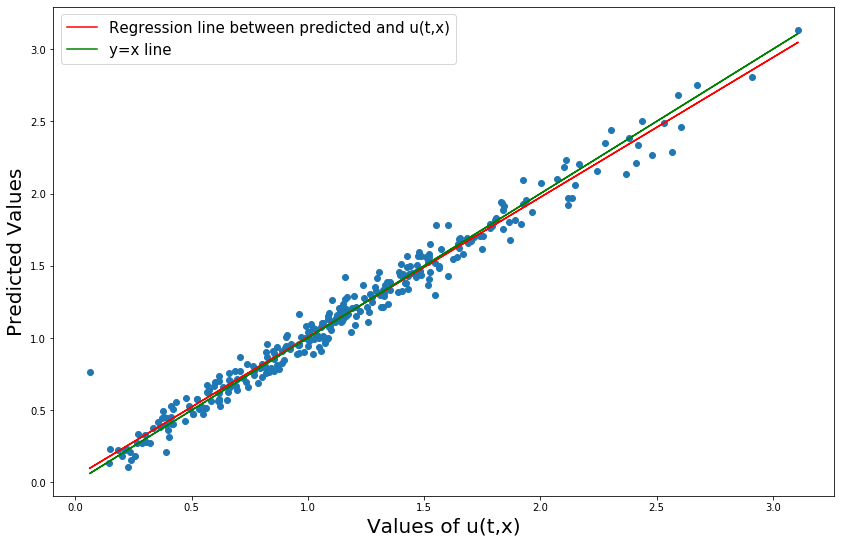

Error: 0.07035890883909046 . Tangent: 0.9679512771432218


In [65]:
t, x = -1, 50 # Point where prediction will be made
E = Experiment(t, x, t, x)
E.F = Features_for_points[(t,x)]
E.one_experiment(None, Soln_mult, split = True)
E.show_regression_experiment()

In [66]:
er1, t1 = E.many_regression_experiments(1000, columns = trees[1])
er2, t2 = E.many_regression_experiments(1000, columns = trees[2])
er3, t3 = E.many_regression_experiments(1000, columns = trees[3])
er4, t4 = E.many_regression_experiments(1000, columns = trees[4])

100%|██████████| 1000/1000 [00:19<00:00, 50.36it/s]


In [67]:
print("Height = 1, average Error:", er1, 'average slope:', t1)
print("Height = 2, average Error:", er2, 'average slope:', t2)
print("Height = 3, average Error:", er3, 'average slope:', t3)
print("Height = 4, average Error:", er4, 'average slope:', t4)

Height = 1, average Error: 0.2373601950151262 average slope: 0.7186339523417096
Height = 2, average Error: 0.13763124795318513 average slope: 0.9089769560511173
Height = 3, average Error: 0.07560442693171897 average slope: 0.9730703230846665
Height = 4, average Error: 0.06823895308883704 average slope: 0.9820011644596492


In [112]:
R_add = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 3) # create rule with additive width 3. No multiplicative component

M_add = Model(integration = I, rule = R_add, height = 5, deg = 7.5) # initialize model for additive equation

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50), (50,50), (200,50), (-1,95), (500,50)}

Features_for_points_add = M_add.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, points = points)

100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s]


100%|██████████| 1000/1000 [00:00<00:00, 6443.47it/s]

Creating labels dataset.


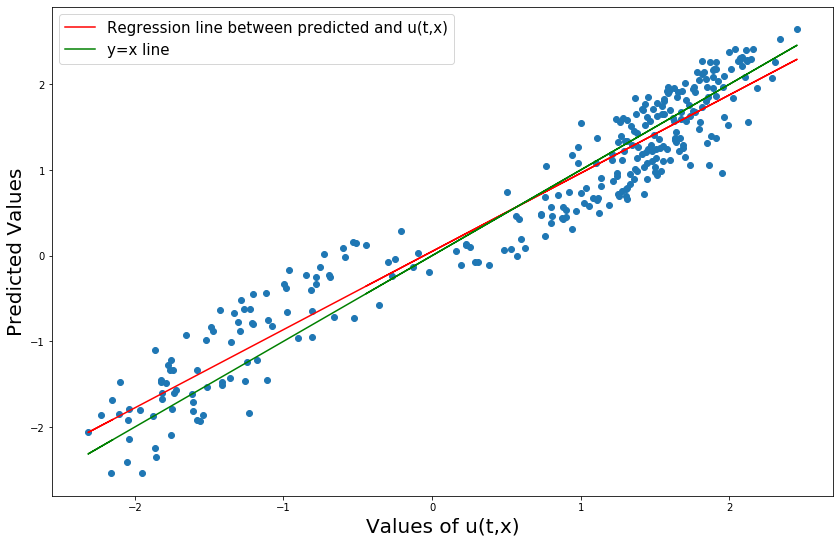

Error: 0.25016028093029724 . Tangent: 0.9130035123667369


In [124]:
t2, x2 = -1, 50 # Point where prediction will be made
E2 = Experiment(t2, x2, t2, x2)
E2.F = Features_for_points_add[(t2,x2)]
E2.one_experiment(None, Soln_add, split = True)
E2.show_regression_experiment()

100%|██████████| 1000/1000 [00:00<00:00, 7516.43it/s]

Creating labels dataset.


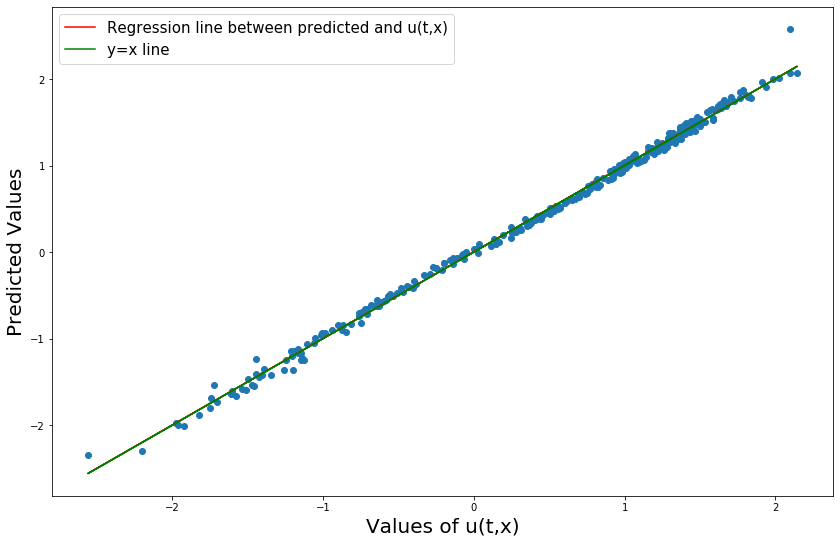

Error: 0.05261714344480932 . Tangent: 0.9998856688838418


In [118]:
t3, x3 = 500, 50 # Point where prediction will be made
E3 = Experiment(t3, x3, t3, x3)
E3.F = Features_for_points_add[(t3,x3)]
E3.one_experiment(None, Soln_add, split = True)
E3.show_regression_experiment()

In [119]:
er_add, t_add = E3.many_regression_experiments(1000)

print("Average error for the additive equation:", er_add)

100%|██████████| 1000/1000 [00:14<00:00, 67.71it/s]

Average error for the additive equation: 0.0630881791929921
